# Introduction :

 L'objectif de ce travail est de créer un modèle d'apprentissage automatique (avec architecture Cnn) ou les  réseaux de neurones convolutifs (CNN) et de l'apprentissage par transfert pour détecter **une pneumonie** à partir d'images radiologiques des poumons d'un patient. En traduisant le problème dans le langage de l'apprentissage automatique, nous sommes confrontés à une tâche de classification binaire. Le prétraitement des données d'entrée, ainsi que la construction d'un modèle d'apprentissage automatique seront effectués à l'aide de TensorFlow, Keras.

# Qu'est-ce qu'une pneumonie ?

La pneumonie est une infection qui enflamme les sacs aériens d'un ou des deux poumons. Les sacs aériens peuvent se remplir de liquide ou de pus (matière purulente), ce qui provoque une toux avec du flegme ou du pus, de la fièvre, des frissons et des difficultés respiratoires. Divers organismes, dont des bactéries, des virus et des champignons, peuvent provoquer une pneumonie.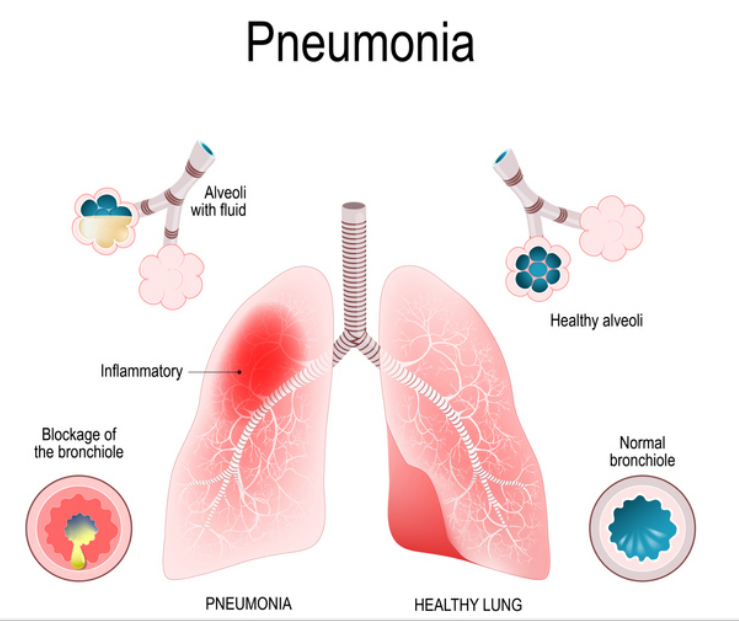

La gravité de la pneumonie peut aller de légère à mortelle. Elle est plus grave chez les nourrissons et les jeunes enfants, les personnes âgées de plus de 65 ans et les personnes ayant des problèmes de santé ou un système immunitaire affaibli.

In [357]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import glob
from tensorflow.keras import callbacks
import tensorflow
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm
from termcolor import colored
from sklearn import metrics
import albumentations as A

# Explore Dataset

**Description de l'ensemble de données sur la pneumonie**

* Le jeu de données est organisé en 3 dossiers (train, test, val) et contient des sous-dossiers pour chaque catégorie d'images (Pneumonie/Normal). Il y a 5 863 images de radiographie (JPEG) et 2 catégories (Pneumonie/Normal). Les images de radiographie du thorax (antérieures-postérieures) ont été sélectionnées à partir de cohortes rétrospectives de patients pédiatriques âgés de un à cinq ans du Guangzhou Women and Children's Medical Center, Guangzhou.

In [268]:
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "../input/chest-xray-pneumonia/chest_xray/"


In [269]:

train_path ="../input/chest-xray-pneumonia/chest_xray/train"
valid_path = "../input/chest-xray-pneumonia/chest_xray/val"
test_path = "../input/chest-xray-pneumonia/chest_xray/test"
train_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
test_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")

In [270]:
print("Il y a {} images dans l'ensemble de données d'entraînement.".format(len(train_df)))
print("Il y a {} images dans le jeu de données de test.".format(len(test_df)))
print("Il y a {} images dans l'ensemble de données de validation.".format(len(validation_df)))

Il y a 5216 images dans l'ensemble de données d'entraînement.
Il y a 624 images dans le jeu de données de test.
Il y a 16 images dans l'ensemble de données de validation.


# Visualisation et prétraitement des données

In [271]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("Le nombre d'images de pneumonie est {}".format(len(pneumonia_lung)))
print("Le nombre d'images de non-pneumonie est {}".format(len(normal_lung)))

Le nombre d'images de pneumonie est 4273
Le nombre d'images de non-pneumonie est 1583


In [272]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
print(images[:10])
len(images)

['../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0364-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0240-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0101-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1028-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0041-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0627-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0523-0001-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1341-0001.jpeg']


100

**Générer un DataFrame Pandas pour les chemins et l'étiquette**

In [273]:
def générer_labels(image_paths):
    labels = []
    for _ in image_paths:
        if ('PNEUMONIA' in _.replace('chest-xray-pneumonia', '')):
            labels.append('PNEUMONIA')
        else:
            labels.append('NORMAL')
            
    return labels
def construire_df(image_paths, labels):
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': générer_labels(labels)
    })
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'NORMAL' else 1, axis=1)
    
    return df.sample(frac=1, random_state=42).reset_index()


In [274]:
# Build the DataFrames
train_df = construire_df(train_df, générer_labels(train_df))
val_df = construire_df(validation_df, générer_labels(validation_df))
test_df = construire_df(test_df, générer_labels(test_df))

NORMAL


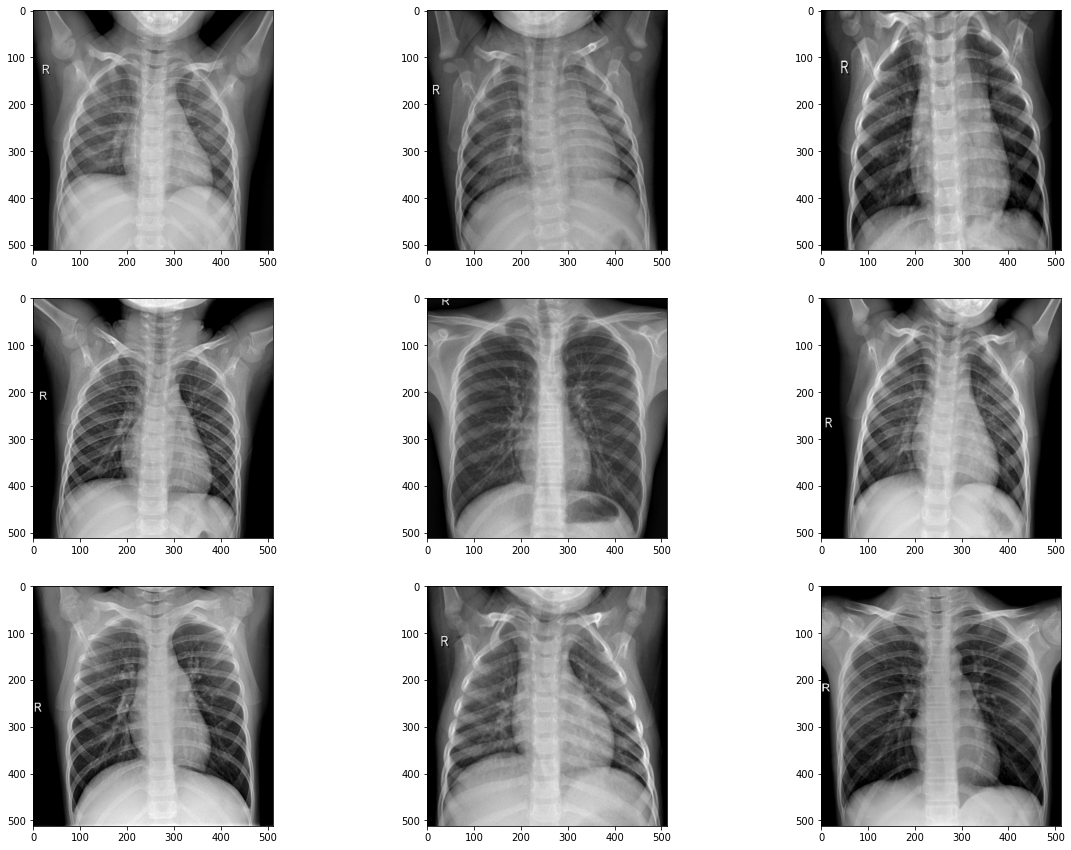

In [275]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
print("NORMAL")
for i in range(1, 10):
   
    img = cv2.imread(normal_lung[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

PNEUMONIA


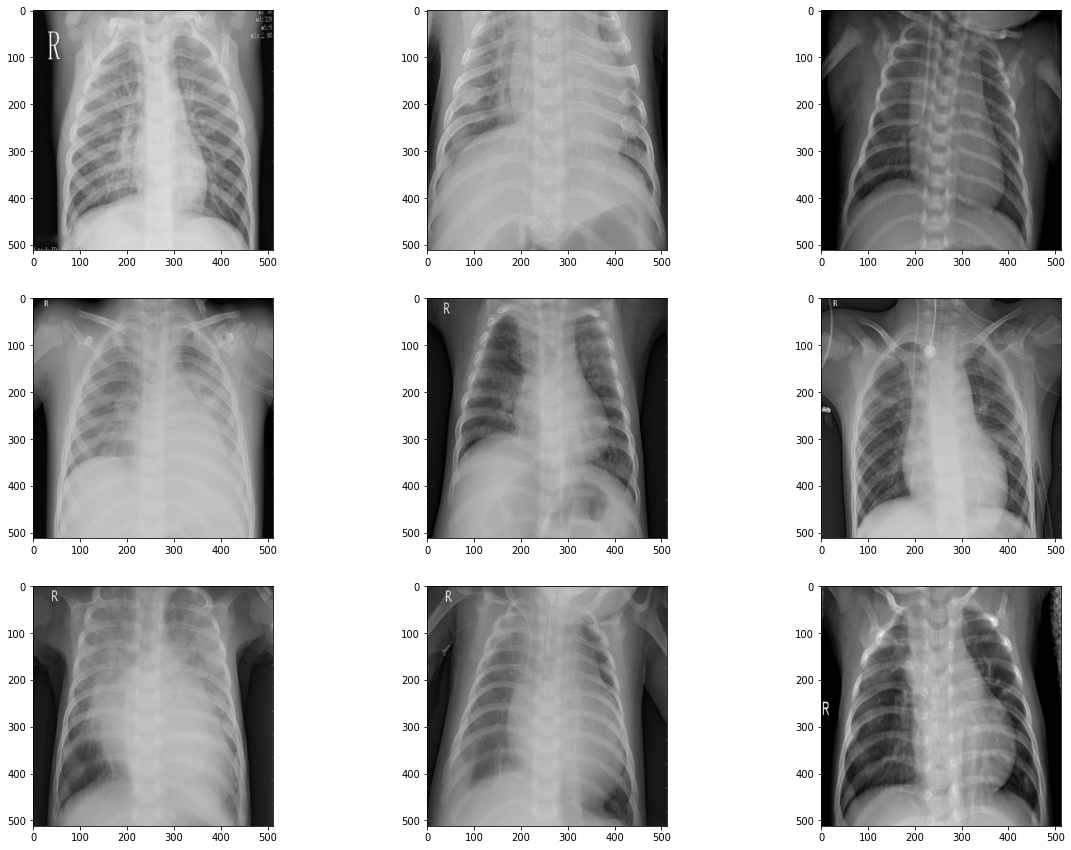

In [276]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
print("PNEUMONIA")
for i in range(1, 10):
    img = cv2.imread(pneumonia_lung[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

**GaussianBlur**

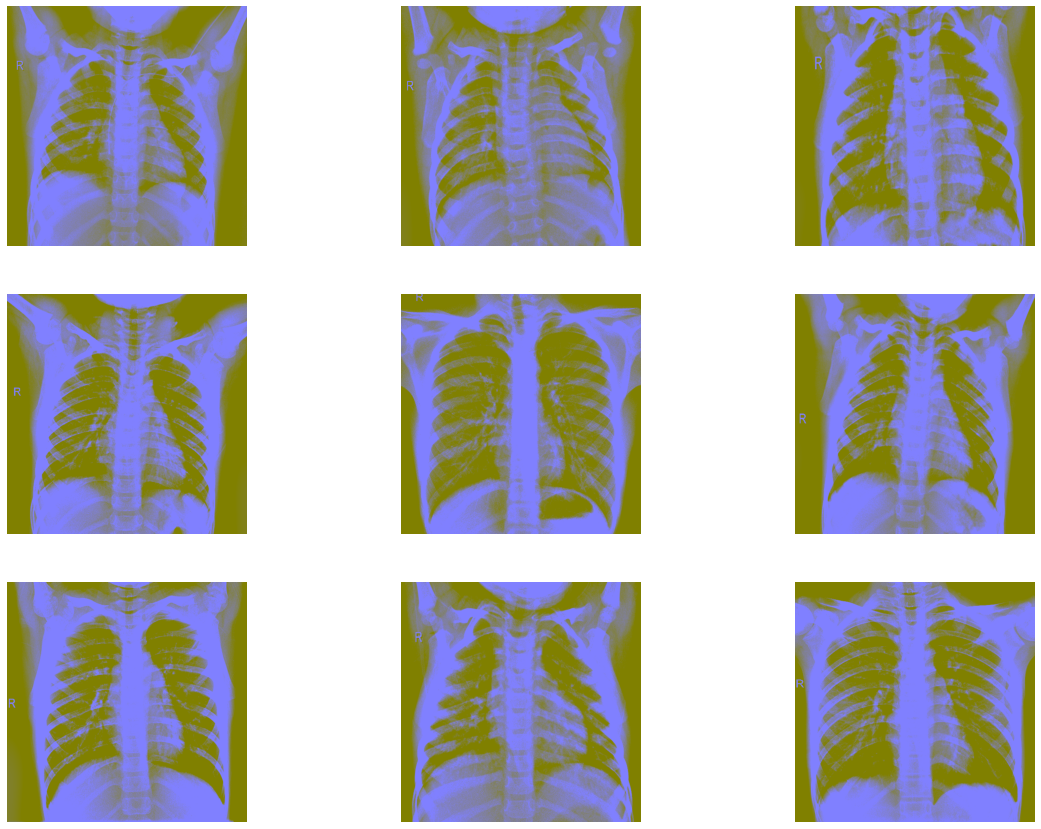

In [277]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

**Canny edge detection:**

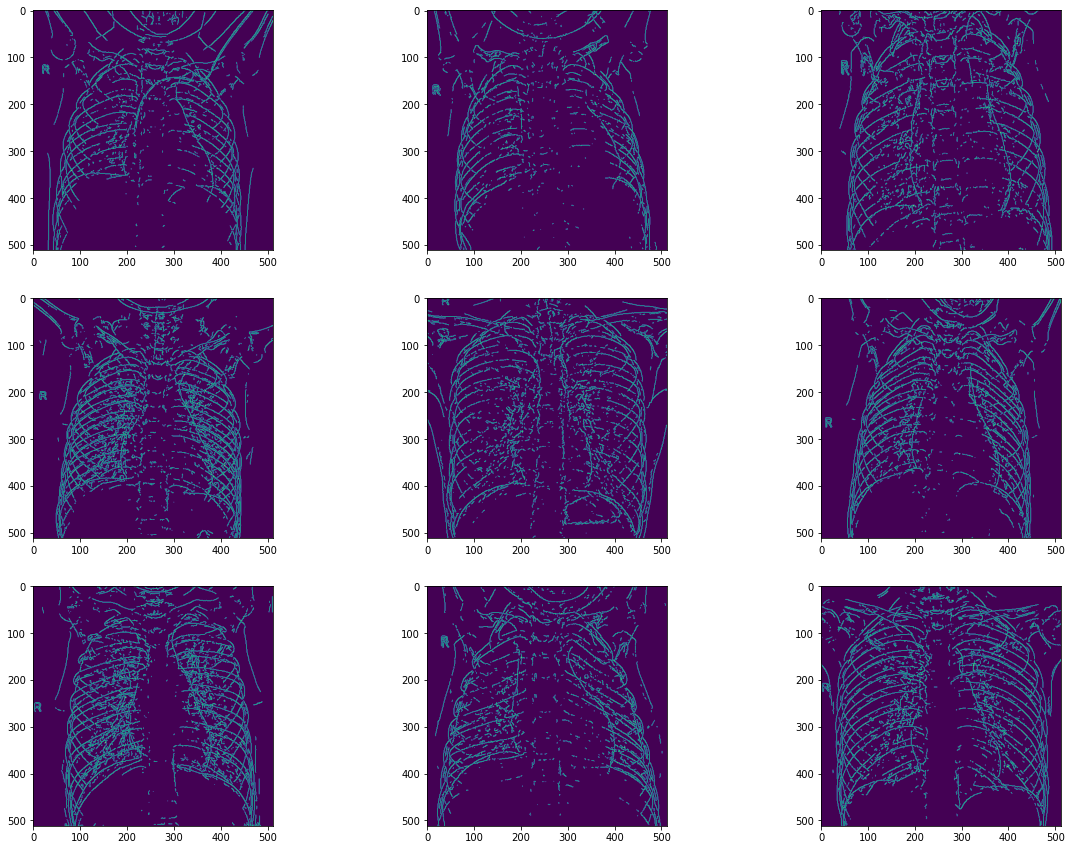

In [278]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

**Nombre d'objets de différentes classes :**

In [279]:
def Count_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

COUNT_NORMAL = Count_label('NORMAL')
COUNT_PNEUMONIA = Count_label('PNEUMONIA')

In [280]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[COUNT_NORMAL, COUNT_PNEUMONIA],
    name='Primary Product',
    marker_color='pink',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [281]:
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_path,
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

valid_dataset = image_dataset_from_directory(valid_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

test_dataset = image_dataset_from_directory(test_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)


rescale = Rescaling(scale=1.0 / 255)
train_d_without_aug = train_dataset.map(lambda image, label: (rescale(image), label))
valid_d_without_aug  = valid_dataset.map(lambda image, label: (rescale(image), label))
test_d_without_aug  = test_dataset.map(lambda image, label: (rescale(image), label))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [282]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# Image and Data Preprocessing 

# Augmentation des données

Afin d'éviter le problème de l'overfitting, nous devons élargir artificiellement notre jeu de données. Nous pouvons rendre notre jeu de données existant encore plus grand. L'idée est de modifier les données d'apprentissage par de petites transformations afin de reproduire les variations. Les approches qui modifient les données d'apprentissage de manière à changer la représentation du tableau tout en conservant l'étiquette sont connues sous le nom de techniques d'augmentation des données. Les augmentations les plus courantes sont les niveaux de gris, les inversions horizontales, les inversions verticales, les coupes aléatoires, les variations de couleur, les translations, les rotations et bien d'autres encore. En appliquant quelques-unes de ces transformations à nos données de formation, nous pouvons facilement doubler ou tripler le nombre d'exemples de formation et créer un modèle très robuste.

**Pour l'augmentation des données, j'ai choisi de :**
* Retourner aléatoirement les images de 10 degrés
* Zoomer aléatoirement les images de 10 %.
* Décalez aléatoirement les images horizontalement de 10 % de la largeur.
* Décalez aléatoirement les images d'un canal de 10 % de la hauteur.


In [283]:
print("Il y a {} images dans l'ensemble de données d'entrainement avant l'augmentation des données.".format(len(train_df)))
print("Il y a {} images dans l'ensemble de données de test avant l'augmentation des données.".format(len(test_df)))
print("Il y a {} images dans l'ensemble de données de validation avant l'augmentation des données.".format(len(validation_df)))

Il y a 5216 images dans l'ensemble de données d'entrainement avant l'augmentation des données.
Il y a 624 images dans l'ensemble de données de test avant l'augmentation des données.
Il y a 16 images dans l'ensemble de données de validation avant l'augmentation des données.


* Maintenant, nous allons charger les images depuis les dossiers et les préparer à alimenter nos modèles.

* Nous commençons par définir les générateurs de données. Avec le générateur de données d'image Keras, nous pouvons remettre à l'échelle les valeurs des pixels et appliquer des techniques de transformation aléatoire pour augmenter les données à la volée. Nous définissons deux générateurs différents. Le générateur val_datagen est utilisé pour simplement redimensionner les ensembles de validation et de test. Le générateur train_datagen inclut certaines transformations pour augmenter l'ensemble de données de formation.

* Nous appliquons les générateurs sur chaque ensemble de données en utilisant la méthode flow_from_dataframe. Outre les transformations définies dans chaque générateur, les images sont également redimensionnées en fonction de l'ensemble target_size.

In [89]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [396]:
IMG_SIZE = 224
BATCH = 32
SEED = 42



train_path = os.path.join(directory,"train")
test_path=os.path.join(directory,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [308]:
len(train_normal)

1341

In [309]:
train_normal=train_normal+val_normal
train_pneumonia=train_pneumonia+val_pneumonia
len(train_normal)

1349

In [311]:
df_test

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
1,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
2,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
3,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
4,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
...,...,...
619,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
620,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
621,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
622,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...


In [310]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [312]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [313]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Construction d'un modèle CNN

* Un réseau neuronal convolutif (CNN) est une architecture de réseau d'apprentissage machine utilisée dans les tâches d'apprentissage profond. Les réseaux neuronaux convolutifs sont utiles pour résoudre des tâches de vision par ordinateur, car ils sont capables d'identifier des modèles dans des données d'image relatives à la classification, à la détection d'objets, à la segmentation d'images, etc. Les CNN sont constitués de couches convolutionnelles qui sont utilisées pour extraire des caractéristiques des données d'image. Pour les problèmes de classification, les CNN comprennent une tête de classification entièrement connectée qui utilise les caractéristiques extraites générées par les couches de convolution pour compléter la tâche de classification de l'image d'entrée.
* Comme nous le savons, la classification d'images implique l'extraction de caractéristiques de l'image pour observer certains modèles dans l'ensemble de données. Le CNN suit un modèle hiérarchique qui travaille sur la construction d'un réseau, comme un entonnoir, et finalement donne une couche entièrement connectée (couche dense) où tous les neurones sont connectés les uns aux autres et la sortie est traitée.CNNs sont très efficaces pour réduire le nombre de paramètres sans perdre sur la qualité des modèles. Les images ont une dimension élevée (chaque pixel étant considéré comme une caractéristique), ce qui convient aux capacités des CNN décrites ci-dessus. Dans les CNN, la réduction de la dimension est réalisée à l'aide d'une fenêtre coulissante dont la taille est inférieure à celle de la matrice d'entrée.

In [67]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [85]:
def cnn_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=(224, 224, 3), dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')
    
    return cnn_sequential

* Nous voyons qu'un réseau neuronal à 4 couches convolutionnelles et 1 couche entièrement connectée est implémenté ci-dessus, un réseau neuronal peu profond qui a une petite profondeur ayant 46 922 paramètres entraînables.

In [86]:
keras.backend.clear_session()
model_cnn = cnn_model()

model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 22472)    

In [90]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = CFG.EPOCHS
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

* Un mécanisme appelé "early stopping" peut également être appliqué. L'arrêt précoce consiste à vérifier si la précision de validation ne s'améliore pas et si ce n'est pas le cas, nous arrêtons la formation même si elle n'atteint pas l'époque finale. De cette façon, nous évitons d'augmenter la différence entre la précision d'entrainement et de validation et nous arrêtons la formation avant que le modèle ne mémorise davantage l'ensemble de données(Overfitting).

In [314]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [315]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [316]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640  

In [317]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 104s 794ms/step - loss: 0.5651 - binary_accuracy: 0.7403 - val_loss: 0.7057 - val_binary_accuracy: 0.7421
Epoch 2/50
130/130 [==============================] - 102s 781ms/step - loss: 0.3548 - binary_accuracy: 0.8385 - val_loss: 1.2114 - val_binary_accuracy: 0.7421
Epoch 3/50
130/130 [==============================] - 103s 787ms/step - loss: 0.2705 - binary_accuracy: 0.8786 - val_loss: 1.4785 - val_binary_accuracy: 0.7421

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
Epoch 4/50
130/130 [==============================] - 103s 789ms/step - loss: 0.2333 - binary_accuracy: 0.9016 - val_loss: 1.0161 - val_binary_accuracy: 0.7421
Epoch 5/50
130/130 [==============================] - 103s 790ms/step - loss: 0.2170 - binary_accuracy: 0.9109 - val_loss: 0.3756 - val_binary_accuracy: 0.8233
Epoch 6/50
130/130 [==============================] - 102s 782ms/step - loss: 0.2214 - binary_accuracy: 0.9125 - val_l

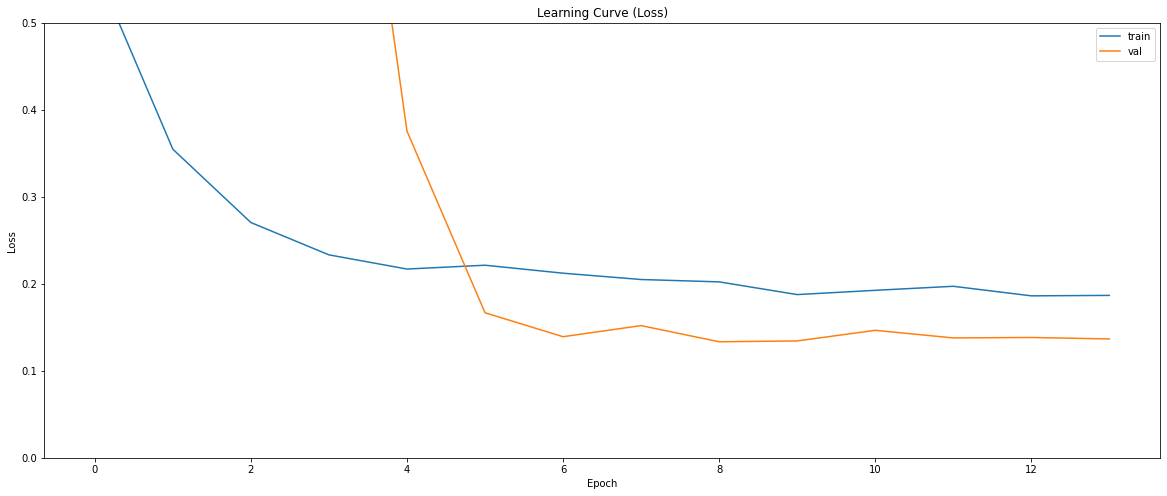

In [318]:

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

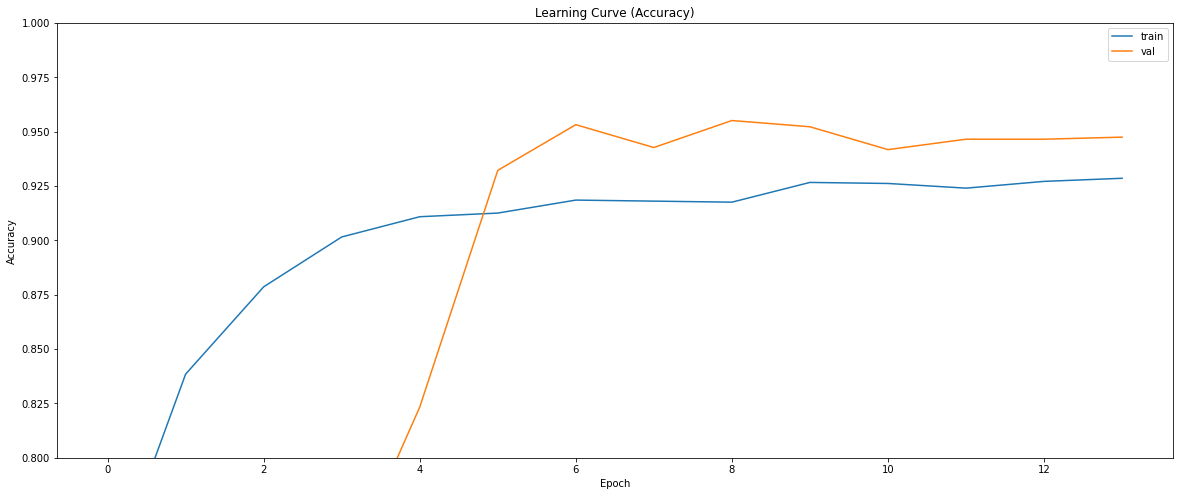

In [319]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

* Nous pouvons voir le processus de l'entrainement et il n'y a pas de surajustement(Overfitting). Pour connaître la qualité de notre modèle, nous devons évaluer ses performances sur le jeu de tests. 

In [320]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.13340571522712708
Val accuracy: 0.9551098346710205


 **Prédiction sur l'ensemble de test :**

* Il est temps de tester notre modèle sur l'ensemble de test et de voir comment il se comporte sur des données qu'il n'a pas vues auparavant. Cette étape est importante, car nous voulons un modèle capable de se généraliser à d'autres ensembles de données que ceux sur lesquels il a été formé. Un modèle qui ne donne de bons résultats que sur l'ensemble de données de formation et de validation, mais pas sur l'ensemble de données de test, n'est pas utile.

In [322]:
score1 = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.516758382320404
Test accuracy: 0.7884615659713745


In [ ]:
res_test_predictions = tf.argmax(model, axis=1)

In [333]:
model.save("/kaggle/working/model")

In [393]:
predictions_cnn = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions_cnn>0.5, 1, 0)

In [394]:
print("Test Accuracy CNN: ", accuracy_score(Y_test, pred_labels))

Test Accuracy CNN:  0.7884615384615384


In [395]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.45      0.62       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.74       624
weighted avg       0.83      0.79      0.76       624



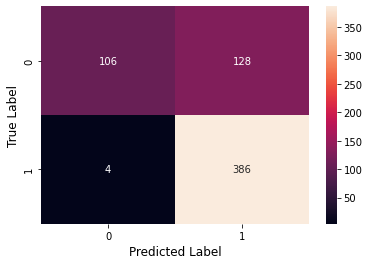

In [365]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()


# Transfer Learning
**Transfer Learning: ResNet50 V2**

Un réseau neuronal résiduel (ResNet) empile des blocs résiduels les uns sur les autres pour former un réseau. ResNet, abréviation de Residual Network, est un type spécifique de réseau neuronal qui a été introduit en 2015 par Kaiming He, Xiangyu Zhang, Shaoqing Ren et Jian Sun dans leur article "Deep Residual Learning for Image Recognition". Les réseaux résiduels profonds, comme le populaire modèle ResNet-50, sont des réseaux neuronaux convolutifs (CNN) d'une profondeur de 50 couches.

In [328]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [329]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [330]:
history1 = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 124s 886ms/step - loss: 0.3715 - binary_accuracy: 0.8478 - val_loss: 0.2132 - val_binary_accuracy: 0.9255
Epoch 2/50
130/130 [==============================] - 111s 851ms/step - loss: 0.2007 - binary_accuracy: 0.9257 - val_loss: 0.1615 - val_binary_accuracy: 0.9370
Epoch 3/50
130/130 [==============================] - 113s 862ms/step - loss: 0.1608 - binary_accuracy: 0.9403 - val_loss: 0.1352 - val_binary_accuracy: 0.9465
Epoch 4/50
130/130 [==============================] - 113s 861ms/step - loss: 0.1496 - binary_accuracy: 0.9467 - val_loss: 0.1268 - val_binary_accuracy: 0.9561
Epoch 5/50
130/130 [==============================] - 113s 863ms/step - loss: 0.1325 - binary_accuracy: 0.9498 - val_loss: 0.1123 - val_binary_accuracy: 0.9551
Epoch 6/50
130/130 [==============================] - 112s 859ms/step - loss: 0.1280 - binary_accuracy: 0.9553 - val_loss: 0.1062 - val_binary_accuracy: 0.9570
Epoch 7/50
130/130 [====================

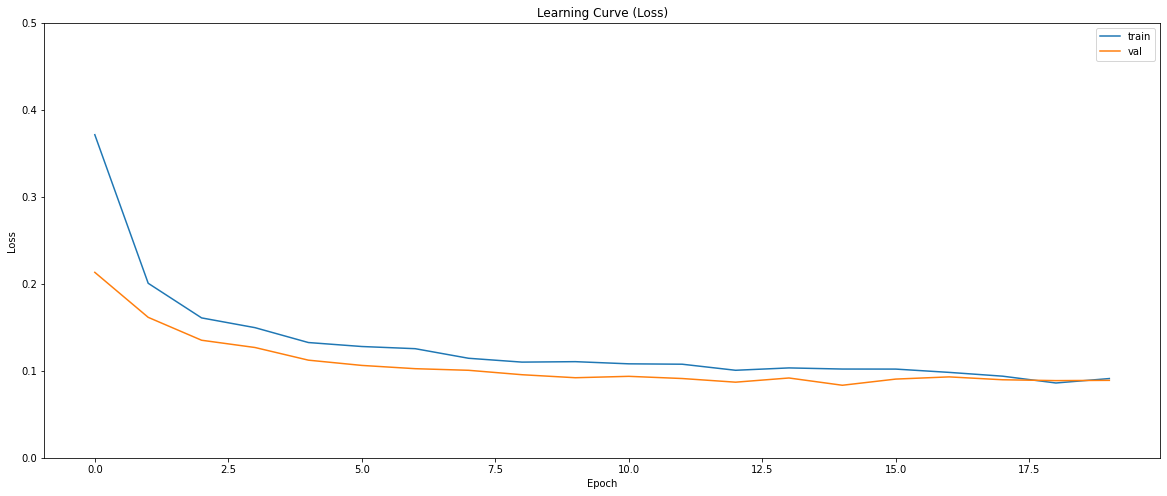

In [343]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history1.epoch, y = history1.history['loss'])
sns.lineplot(x = history1.epoch, y = history1.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

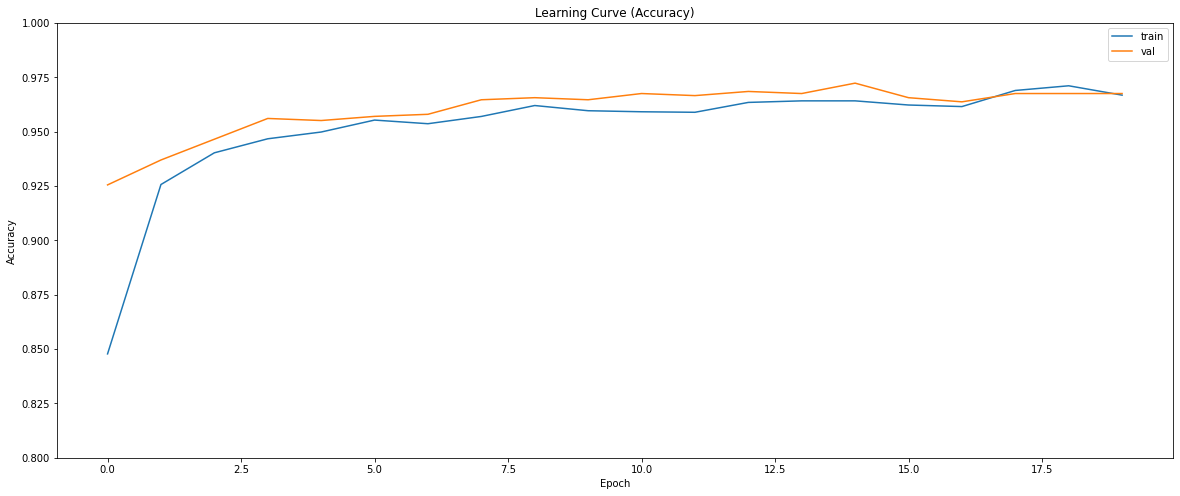

In [342]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history1.epoch, y = history1.history['binary_accuracy'])
sns.lineplot(x = history1.epoch, y = history1.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [344]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.12076888233423233
Val accuracy: 0.9560649394989014


In [345]:
score1 = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.329448938369751
Test accuracy: 0.8733974099159241


In [331]:
model_pretrained.save("/kaggle/working/modelresent")

2023-01-15 19:50:24.622263: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Fine Tuning

* Notre dernière approche est appelée Fine Tuning. Dans la section précédente, toutes les couches du modèle pré-entraîné ont été " frozen ", en conservant les poids calculés pendant son entraînement sur le jeu de données ImageNet. Maintenant, nous allons dégeler quelques-unes de ses dernières couches et continuer l'entraînement, en ajustant les poids de ces couches en fonction de notre jeu de données.

In [334]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [335]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [337]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 4,731,137
Non-trainable params: 53,862,912
_________________________________________

In [346]:
history2 = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 113s 867ms/step - loss: 0.1241 - binary_accuracy: 0.9591 - val_loss: 0.1195 - val_binary_accuracy: 0.9589
Epoch 2/50
130/130 [==============================] - 112s 860ms/step - loss: 0.1203 - binary_accuracy: 0.9587 - val_loss: 0.1127 - val_binary_accuracy: 0.9580
Epoch 3/50
130/130 [==============================] - 113s 867ms/step - loss: 0.1194 - binary_accuracy: 0.9565 - val_loss: 0.1116 - val_binary_accuracy: 0.9608
Epoch 4/50
130/130 [==============================] - 113s 861ms/step - loss: 0.1109 - binary_accuracy: 0.9627 - val_loss: 0.1107 - val_binary_accuracy: 0.9599
Epoch 5/50
130/130 [==============================] - 114s 866ms/step - loss: 0.1082 - binary_accuracy: 0.9632 - val_loss: 0.1058 - val_binary_accuracy: 0.9618
Epoch 6/50
130/130 [==============================] - 114s 875ms/step - loss: 0.1044 - binary_accuracy: 0.9637 - val_loss: 0.1034 - val_binary_accuracy: 0.9628
Epoch 7/50
130/130 [====================

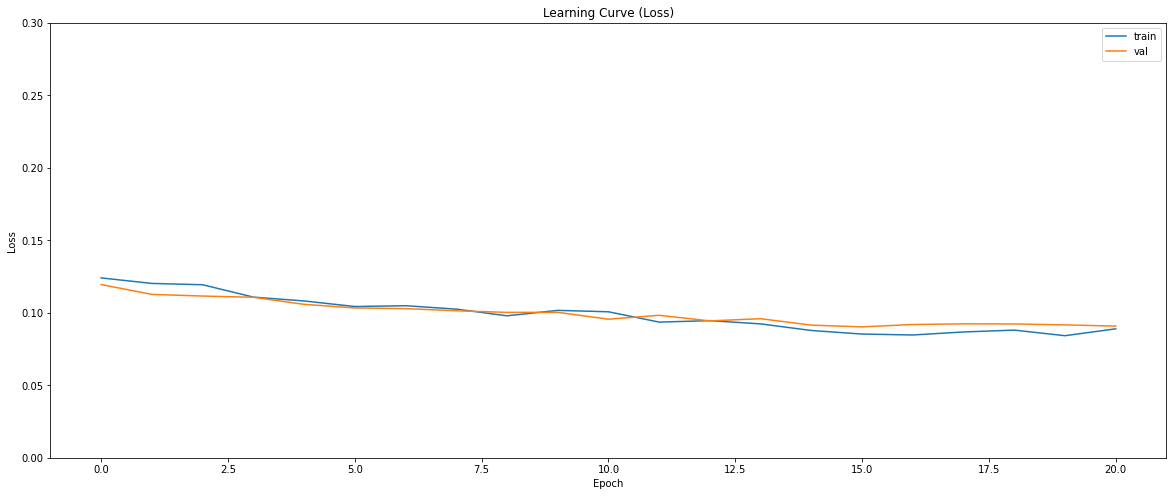

In [348]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history2.epoch, y = history2.history['loss'])
sns.lineplot(x = history2.epoch, y = history2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

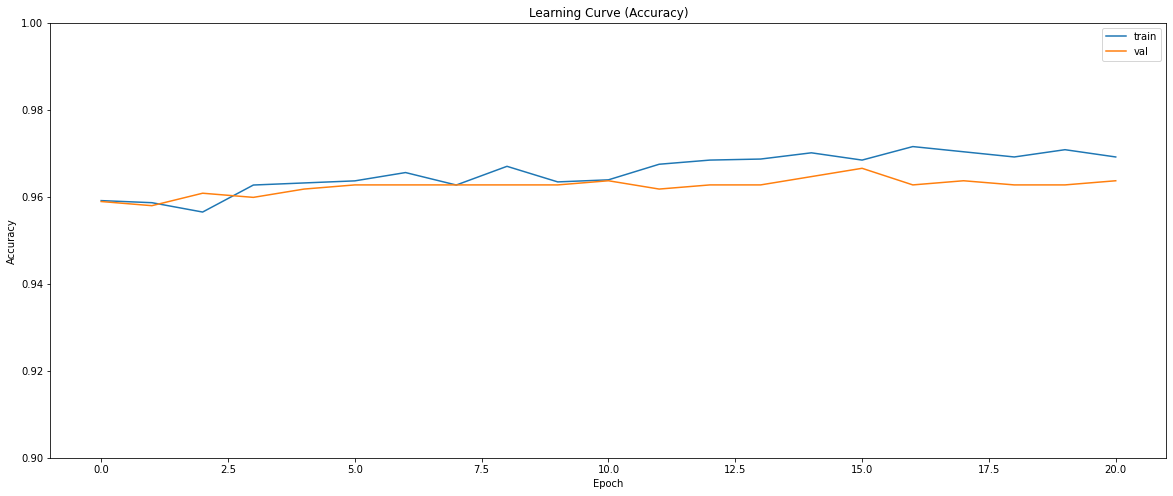

In [349]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history2.epoch, y = history2.history['binary_accuracy'])
sns.lineplot(x = history2.epoch, y = history2.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [350]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09034226089715958
Val accuracy: 0.9665711522102356


In [351]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3552650809288025
Test accuracy: 0.8766025900840759


Il s'agit des résultats les plus robustes et les meilleurs que nous ayons obtenus jusqu'à présent, avec une précision d'entrainement ≈  0,88 et une précision de validation = 0,96. Bien sûr, nous avions une meilleure précision avec la version précédente, mais elle était surajustée ! La précision d'apprentissage ne signifie pas une belle réussite si la précision de validation n'a pas la même performance.

**Mesures de la performance**

In [353]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [354]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [355]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8766025641025641


**Métriques d'évaluation des modèles**

* Ensuite, nous obtenons une mesure de la performance de notre modèle en évaluant plusieurs métriques des prédictions par rapport aux étiquettes cibles réelles.

* La précision n'est pas une bonne mesure d'évaluation lorsqu'il y a un grand déséquilibre entre les classes de données. Imaginons que nous ayons 100 échantillons : 99 pneumonies et 1 normal, alors un modèle qui prédit tout comme pneumonie aura une précision de 99%. Dans ce cas, il est préférable d'examinerle rappel, ainsi que leur moyenne harmonique, le score F1.

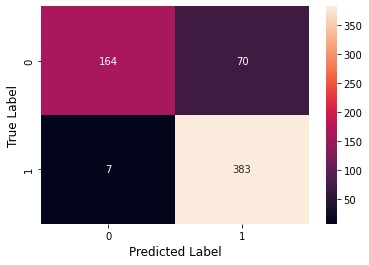

In [358]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [359]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



ROC_AUC:  0.958809993425378


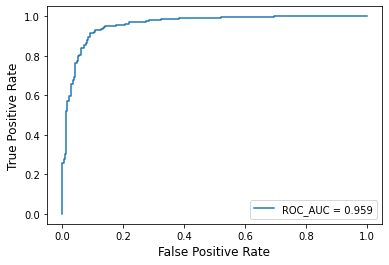

In [360]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [ ]:
model_pretrained.save("/kaggle/working/bestmodel")

In [390]:
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
test_data, test_labels = [], []
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [385]:
predictions = list()
preds = model_pretrained.predict(ds_test)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [386]:
correct= np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  2  4  5  6  7  8  9 10 11 14 15 16 17 20]

Indices of incorrect predictions:
 [ 1  3 12 13 18 19 22 24 25 26 31 32 33 35 47]


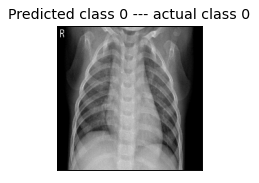

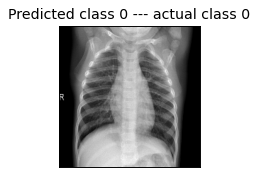

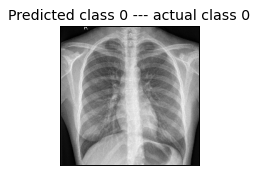

In [387]:
i = 0
for a in correct[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

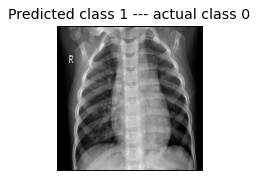

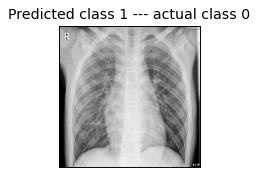

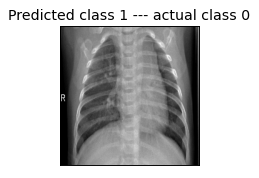

In [388]:
i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

# Conclusion :
* Le rappel était proche de 100%. Même sans expertise dans le domaine médical, il est raisonnable de supposer que les faux négatifs sont plus "coûteux" que les faux positifs dans ce cas. Atteindre un tel taux de rappel avec un ensemble de données relativement petit pour la formation comme celui-ci, tout en atteignant également un assez bon taux de rappel, est une bonne indication des capacités du modèle. Ces capacités sont également confirmées par la valeur élevée du ROC-AUC.